In [2]:
import warnings
warnings.simplefilter(action='ignore')

import seaborn as sns 
import numpy as np
import pandas as pd 
import pathlib
import json 
from matplotlib import pyplot as plt 
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 18, 'lines.markeredgewidth': 5})
# sns.set_style(style='ticks')


# color scheme

# 'email_querycontact', 'general_quirky', 'play_radio', 'traffic', 'email_query'
# colors = ['#7f3b08','#b35806','#e08214','#fdb863','#fee0b6','#d8daeb','#b2abd2','#8073ac','#542788','#2d004b'] 
colors = ['#7f3b08','#b35806','#e08214','#fdb863','#8e0152','#d73027','#4575b4','#b2abd2','#8073ac','#542788','#2d004b']
intents_and_functions = ['play_radio', "FindManager", 'email_query', "Tomorrow", 'email_querycontact', "PlaceHasFeature", 'general_quirky', "DoNotConfirm", 'traffic', "FenceAttendee", "total"]
color_mapping = {k:v for k,v in zip(intents_and_functions, colors)}

marker_lookup = {'play_radio': "d", "FindManager": "o", 'email_query': "H", "Tomorrow": "P", 'email_querycontact': "^", "PlaceHasFeature": ">", 'general_quirky': "s", "DoNotConfirm": "p", 'traffic': "8", "FenceAttendee": "*", "total": "D"}



In [3]:
name_lookup = {"valid_em": "Exact Match", "valid_coarse": "Coarse", "valid_fine": "Fine", "valid_precision": "Precision", 
               "test_em": "Exact Match", "test_coarse": "Coarse", "test_fine": "Fine", "test_precision": "Precision"}
def plot_calflow(datas, title, savepath=None, fixed_axis=False, prefix="valid", 
        xs = ["5000","10000","20000","50000","100000","max"], 
        ax = None, use_total=True, use_coarse=False, add_nums=False, ymin = None, ymax=None,
        legend_kws={}):

    all_data = {}
    for i, (fxn, data) in enumerate(datas):
        col_names = ['train', fxn]
        if use_total or i == 0:
            col_names.append("total")
        if use_coarse:
            col_names.append(f"{prefix}_coarse")

        data['train'] = data['train'].astype(str)
        data = data.rename(columns={"train": "train", "function": "function", "seed": "seed", "test_coarse": "test_coarse", f"{prefix}_em": f"total", f"{prefix}_fine": fxn} )
        minor_data = data[col_names]
        minor_data = pd.melt(minor_data, id_vars=['train'])
        all_data[fxn] = minor_data
    big_data = pd.concat(all_data.values(), ignore_index=True)
    # sns.set_style(style='ticks')
    # sns.set_theme(font_scale = 1.1, style="ticks", context = "paper") 
    if ax is None:
        fig, ax = plt.subplots()

    # custom_palette = [color_mapping[k] for k in sorted(['FindManager', 'Tomorrow', 'PlaceHasFeature', 'DoNotConfirm', 'FenceAttendee', 'total'])]
    # custom_palette = sns.color_palette(custom_palette)
    # print(custom_palette)
    sns.set_theme(font_scale = 1.1, style="ticks", context = "paper") 
    sns.lineplot(data=big_data, 
                x="train", 
                y="value",  
                hue="variable", 
                err_style="band", 
                # err_kws={"capsize":7, "markeredgewidth":2,  "elinewidth":2}, 
                style = "variable", 
                markers=marker_lookup,
                dashes=False,
                markersize=7,
                linewidth=3,
                ax=ax, 
                palette=color_mapping)
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
    sns.set_theme(font_scale = 1.1, style="ticks", context = "paper") 

    # if add_nums:
    #     for i, num in enumerate(xs):
    #         for var in [f'{prefix}_em', f'{prefix}_coarse', f'{prefix}_fine']:
    #             data_subset = minor_data[minor_data['train'] == str(num)] 
    #             data_subset = data_subset[data_subset['variable'] == var]
    #             mean_value = data_subset.mean()['value']
    #             ax.annotate(f"{mean_value:.2f}", (i, mean_value))

    if fixed_axis:
        ax.ylim(20, 100)
    if ymin is not None:
        ax.set_ylim(bottom=ymin)
    if ymax is not None:
        ax.set_ylim(top=ymax)
    # sns.set(font_scale = 1.1)
    ax.set_title(title, fontsize=14)
    ax.set_ylabel("")
    ax.set_xlabel("Total Training Examples")
    # try:
    #     legend = ax.get_legend()
    #     handles, labels = legend.legendHandles, legend.texts

    #     text_labels = []
    #     for i, text in enumerate(labels):
    #         text_labels.append(name_lookup[text._text])

    #     ax.legend(handles, text_labels)
    # except AttributeError:
    #     pass

    ax.legend(**legend_kws)


    # sns.set(font_scale = 1.1)

    if savepath is not None:
        plt.tight_layout()
        plt.savefig(savepath)



In [4]:


def get_data_from_dir(root_data_dir, fxn, seeds):
    all_data = pd.DataFrame(columns=["train", "function", "seed", "total_acc", f"{fxn}_acc", "intent"], dtype=object)
    root_data_dir = pathlib.Path(root_data_dir).joinpath(str(fxn))
    for seed in seeds:
        data_dir = root_data_dir.joinpath(f"{seed}_seed")

        globs = [x for x in data_dir.glob("*/test_metrics.json")]
        globs = sorted(globs, key = lambda x: int(x.parent.name.split("_")[0]))

        for path in globs:
            try:
                data = json.load(open(path))
            except json.JSONDecodeError:
                data = {}
                data['acc'] = np.nan
                data[f'{fxn}_acc'] = np.nan

            setting = path.parent.name
            num_train, num_fxn = setting.split("_")
            num_train, num_fxn = int(num_train), int(num_fxn)

            to_add = {"train": str(num_train), "function": num_fxn, "seed": seed, 
                     "total_acc": data['acc'] * 100, "intent": fxn, f"{fxn}_acc": data[f"{fxn}_acc"] * 100}
            all_data = all_data.append(to_add, ignore_index=True)

    return all_data 

name_mapping = {"50": "play_radio", "66": "traffic", "15": "email_query", "16": "email_querycontact", "27": "general_quirky"}
def plot_intent(data_dirs, 
                seeds = [12, 31, 64], 
                title=None, 
                savepath=None, 
                fixed_axis=False, 
                xs = [750, 1500, 3000, 7500, 15000, 18000], 
                ax = None, 
                fxn_split = 15,
                axis_title = None,
                legend_kws = {}):
    all_data = {}

    for i, (intent, data_dir) in enumerate(data_dirs):
        data = get_data_from_dir(data_dir, intent, seeds)
        data = data[data['function'] == fxn_split]
        if i == 0:
            col_names = ["train", "total_acc", f"{intent}_acc"]
        else:
            col_names = ["train", f"{intent}_acc"]

        minor_data = data[col_names]
        minor_data = minor_data.rename(columns={"train": "train", 
                                        "total_acc": "total", 
                                        f"{intent}_acc": name_mapping[str(intent)]})
        minor_data = pd.melt(minor_data, id_vars=['train'])
        all_data[intent] = minor_data

    if ax is None:
        fig, ax = plt.subplots()

    big_data = pd.concat(all_data.values(), ignore_index=True) 

    # custom_palette = [color_mapping[k] for k in sorted([ '15', 'total', '16', '27', '50', '66'])]
    # custom_palette = sns.color_palette(custom_palette)
    # print(custom_palette)

    sns.set_theme(font_scale = 1.1, style="ticks", context = "paper") 
    sns.lineplot(data=big_data, 
                x="train", 
                y="value",  
                hue="variable", 
                err_style="band",
                markers=marker_lookup,
                style="variable",
                dashes=False,
                # err_kws={"capsize":7, "markeredgewidth":2,  "elinewidth":2}, 
                # marker = "o", 
                markersize=7,
                linewidth=3,
                ax=ax, 
                palette=color_mapping)
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
    sns.set_theme(font_scale = 1.1, style="ticks", context = "paper") 

    # for i, num in enumerate(xs):
    #     for var in ['total_acc', 'fxn_acc']:
    # #     for var in [f'{prefix}_em', f'{prefix}_coarse', f'{prefix}_fine']:
    #         data_subset = minor_data[minor_data['train'] == str(num)] 
    #         data_subset = data_subset[data_subset['variable'] == var]
    #         mean_value = data_subset.mean()['value']
    #         ax.annotate(f"{mean_value:.2f}", (i, mean_value))

    # if fixed_axis:
    #     ax.ylim(20, 100)

    # # sns.set(font_scale = 1.1)
    ax.set_title(title, fontsize=14)
    ax.set_ylabel("")

    if axis_title is not None:
        ax.set_xlabel("Total Training Examples")
    else:
        ax.set_xlabel("") 

    ax.legend(**legend_kws)

    # sns.set(font_scale = 1.1)

    if savepath is not None:
        plt.tight_layout()
        plt.savefig(savepath)




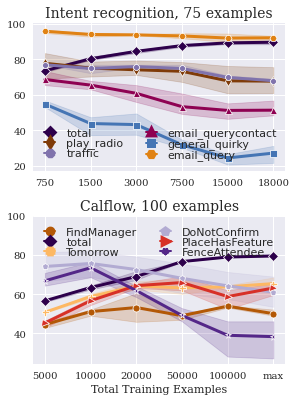

In [5]:
# Figure 1: showing decreasing accuracy for both intent and calflow 
from matplotlib.legend_handler import HandlerLine2D

plt.rcParams.update({'font.size': 24, 'lines.markeredgewidth': 5, 'font.family': "DejaVu Serif"})


def update(handle, orig):
    handle.update_from(orig)
    handle.set_linewidth(2)

handler_map={plt.Line2D : HandlerLine2D(update_func=update)}

fig, ax = plt.subplots(2, 1, sharex=False, sharey=False, figsize = (4.3, 5.7))

plot_intent([(50, "/brtx/603-nvme1/estengel/intent_fixed_test/intent/"),
             (66, "/brtx/603-nvme1/estengel/intent_fixed_test/intent/"), 
             (16, "/brtx/603-nvme1/estengel/intent_fixed_test/intent/"), 
             (27, "/brtx/603-nvme1/estengel/intent_fixed_test/intent/"), 
             (15, "/brtx/603-nvme1/estengel/intent_fixed_test/intent/")], [12, 31, 64],
              title = f"Intent recognition, 75 examples", fxn_split=75, ax=ax[0],
              axis_title=None,
              legend_kws=dict(ncol=2, fontsize=11, borderpad=0.5, labelspacing=0.0, handlelength=1,
                              handletextpad=1.0, handler_map=handler_map))

fm_data = pd.read_csv("~/papers/incremental_function_learning/results/FindManager_transformer_test.csv", index_col=0)
tomorrow_data = pd.read_csv("~/papers/incremental_function_learning/results/Tomorrow_transformer_test.csv", index_col=0)
donotconfirm_data = pd.read_csv("~/papers/incremental_function_learning/results/DoNotConfirm_transformer_full_test.csv", index_col=0)
placehasfeature_data = pd.read_csv("~/papers/incremental_function_learning/results/PlaceHasFeature_transformer_test.csv", index_col=0)
fenceattendee_data = pd.read_csv("~/papers/incremental_function_learning/results/FenceAttendee_transformer_test.csv", index_col=0)

datas = [("FindManager", fm_data), ("Tomorrow", tomorrow_data), ("DoNotConfirm", donotconfirm_data), ("PlaceHasFeature", placehasfeature_data), ("FenceAttendee", fenceattendee_data)]
plot_calflow(datas, 
            title = "Calflow, 100 examples", 
            prefix="test", 
            ax=ax[1], 
            use_coarse=False, 
            use_total=False,
            ymin=None,
            ymax=100,
            legend_kws=dict(ncol=2, fontsize=11, borderpad=0.5, labelspacing=0.0, handlelength=1,
                              handletextpad=1.0, handler_map=handler_map)
            )

plt.tight_layout()

plt.savefig("/home/estengel/papers/incremental_function_learning/figures/for_paper/fig1_intent_and_calflow.pdf")

In [6]:

import sys
sys.path.insert(0, "/home/estengel/incremental-function-learning/scripts")


from derivative_metric import prepare_latex

# intent 
paths = {"baseline": "/brtx/603-nvme1/estengel/intent_fixed_test/intent/",
                "remove source": "/brtx/603-nvme1/estengel/intent_fixed_test/intent_no_source",
                "upsample_16": "/brtx/606-nvme1/estengel/intent_fixed_test/intent_upsample_16.0",
                "upsample_32": "/brtx/606-nvme1/estengel/intent_fixed_test/intent_upsample_32.0"}
functions_and_names = [ (50, "play_radio"), (66, "transit_traffic"), (15, "email_query"), (16, "email_querycontact"), (27, "general_quirky")]
numbers = [15, 30, 75]

paths_and_settings = []

for num in numbers:
    for fxn, name in functions_and_names:
        for model_name, path in paths.items():
            paths_and_settings.append((path, (fxn, name, num, model_name)))


data_df = prepare_latex(paths_and_settings, is_intent= True)


mean: -1.1392841824379205 +/- 0.29678886629710843
mean: -0.13724225843693605 +/- 0.3890485077931298
mean: -0.5686671833181897 +/- 0.16482763802801495
mean: -0.6111746220087452 +/- 0.3348804612216729
mean: -0.2571240693682846 +/- 0.19256783962120727
mean: 0.014370074581141099 +/- 0.14130934747194468
mean: -0.3382127418187513 +/- 0.12386304178253914
mean: -0.19180142176392487 +/- 0.037160569939435104
mean: -0.04172404007309375 +/- 0.4487817169366239
mean: -0.0038423561287327657 +/- 0.09583508367279372
mean: -0.04750555831048764 +/- 0.04467048423249209
mean: -0.05266017239109589 +/- 0.1375244012090754
mean: -0.9974641483036013 +/- 0.88579015988736
mean: 0.28430754135127595 +/- 0.695101027899188


KeyboardInterrupt: 

In [ ]:

def add_lines(ax, baseline_df, comp_df, x_name, y_name):
    for baseline_idx, baseline_row in baseline_df.iterrows():
        comp_idxs = comp_df['seed'] == baseline_row['seed']
        for key in ["function", "examples"]:
            comp_idxs &= comp_df[key] == baseline_row[key]
        comp_row = comp_df[comp_idxs]
        bx, by = baseline_row[x_name], baseline_row[y_name]
        cx, cy = comp_row[x_name], comp_row[y_name]
        try:
            ax.plot([bx,cx], [by, cy], color='grey', linewidth=0.5)
        except ValueError:
            pass


def linked_point_plot(ax, df, baseline_name="baseline", comparison_name="remove source", title="", reduction=None):
    print(df.head())
    if reduction == "mean": 
        mean_data_df = df.set_index(["examples", "function", "setting"]).mean(level=['examples', 'function', 'setting'])
        df = mean_data_df.reset_index(level=['examples', 'function', 'setting']) 
        print(df.head())

    baseline_idxs = df['setting']  == baseline_name
    comp_idxs = df['setting'] == comparison_name
    df = df[baseline_idxs | comp_idxs]
    df['x_value'] = [0 if row[1]['setting'] == baseline_name else 1 for row in df.iterrows()]
    
    sns.scatterplot(data = df, x="x_value", y = "deriv_metric", hue="function", ax = ax)
    ax.set_xticks([0, 1])
    ax.set_xticklabels([baseline_name, comparison_name], rotation=15)

    # add lines 
    baseline_df = df[baseline_idxs]
    comp_df = df[comp_idxs]
    add_lines(ax, baseline_df, comp_df, "x_value", "deriv_metric")

    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("Deriv metric")

def min_or_max_plot(ax, df, x_name = "max_x", y_name = "max_acc",  baseline_name="baseline", comparison_name = "remove source", title="", reduction=None):
    if reduction == "mean": 
        mean_data_df = df.set_index(["examples", "function", "setting"]).mean(level=['examples', 'function', 'setting'])
        df = mean_data_df 
    # df[x_name] = np.log(df[x_name])
    baseline_idxs = df['setting']  == baseline_name
    comp_idxs = df['setting'] == comparison_name
    df = df[baseline_idxs | comp_idxs]
    sns.scatterplot(data=df, x=x_name, y=y_name, hue = "setting", ax = ax)

    baseline_df = df[baseline_idxs]
    comp_df = df[comp_idxs]
    add_lines(ax, baseline_df, comp_df, x_name, y_name)

    ax.set_title(title)



#.mean(level="train")

# print(data_df.head())
fig, ax = plt.subplots(1, 3, sharex = False, sharey=True, figsize=(10, 4))

linked_point_plot(ax[0], data_df, title="Delta metric", reduction="mean")
# linked_point_plot(ax[1], data_df, title="Delta metric", baseline_name='baseline', comparison_name="upsample_32")
# linked_point_plot(ax[2], data_df, title="Delta metric", baseline_name='baseline', comparison_name="upsample_16")

# fig, ax = plt.subplots(1, 3, sharex = True, sharey=True, figsize=(10, 4))
# min_or_max_plot(ax[0], data_df, x_name = 'min_x', y_name = 'min_acc', baseline_name='baseline', comparison_name="remove source")
# min_or_max_plot(ax[1], data_df, x_name = 'min_x', y_name = 'min_acc', baseline_name='baseline', comparison_name="upsample_32", title="Minumum x and accuracy")
# min_or_max_plot(ax[2], data_df, x_name = 'min_x', y_name = 'min_acc', baseline_name='baseline', comparison_name="upsample_16")


# fig, ax = plt.subplots(1, 3, sharex = True, sharey=True, figsize=(10, 4))
# min_or_max_plot(ax[0], data_df, x_name = 'max_x', y_name = 'max_acc', baseline_name='baseline', comparison_name="remove source")
# min_or_max_plot(ax[1], data_df, x_name = 'max_x', y_name = 'max_acc', baseline_name='baseline', comparison_name="upsample_32", title="Max x and accuracy")
# min_or_max_plot(ax[2], data_df, x_name = 'max_x', y_name = 'max_acc', baseline_name='baseline', comparison_name="upsample_16")


In [ ]:
# data_df = data_df.set_index("train")


In [ ]:
# print(data_df.head())

mean_data_df = data_df.set_index(["examples", "function", "setting"]).mean(level=['examples', 'function', 'setting'])
print(mean_data_df.head())

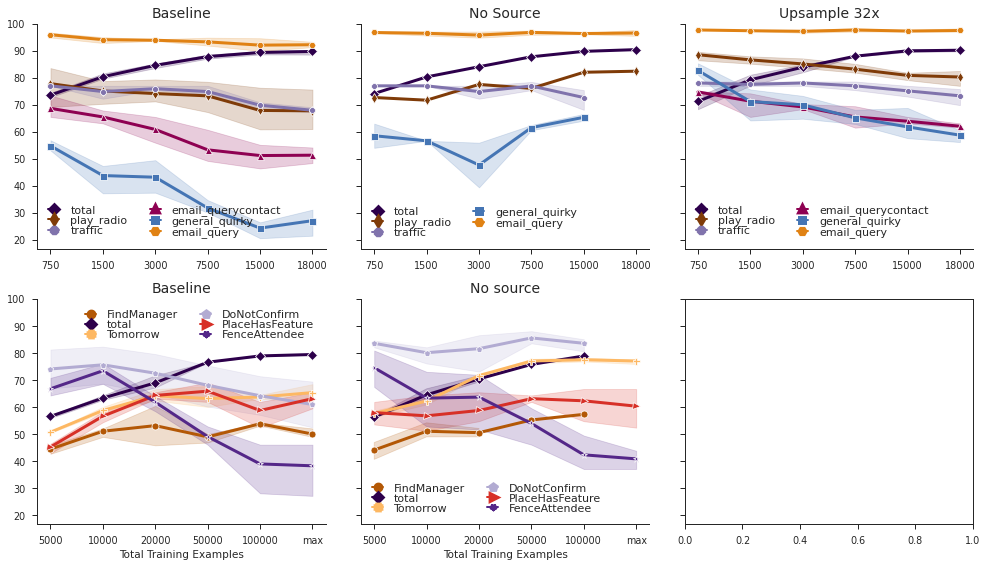

In [9]:

# cross-ways plot 
fig, ax = plt.subplots(2, 3, sharex=False, sharey=True, figsize=(14, 8))


plot_intent([(50, "/brtx/603-nvme1/estengel/intent_fixed_test/intent/"),
             (66, "/brtx/603-nvme1/estengel/intent_fixed_test/intent/"), 
             (16, "/brtx/603-nvme1/estengel/intent_fixed_test/intent/"), 
             (27, "/brtx/603-nvme1/estengel/intent_fixed_test/intent/"), 
             (15, "/brtx/603-nvme1/estengel/intent_fixed_test/intent/")], [12, 31, 64],
              title = f"Baseline", fxn_split=75, ax=ax[0, 0],
              axis_title=None,
              legend_kws=dict(ncol=2, fontsize=11, borderpad=0.5, labelspacing=0.0, handlelength=1,
                              handletextpad=1.0, handler_map=handler_map))

# plot_intent([(50, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_no_source_manual/"),
#              (66, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_no_source_manual/"), 
#              (16, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_no_source_manual/"), 
#              (27, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_no_source_manual/"), 
#              (15, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_no_source_manual/")], [12, 31, 64],
#               title = f"No Source", fxn_split=75, ax=ax[0, 1],
#               axis_title=None,
#               legend_kws=dict(ncol=2, fontsize=11, borderpad=0.5, labelspacing=0.0, handlelength=1,
#                               handletextpad=1.0, handler_map=handler_map))

plot_intent([(50, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_no_source_manual/"),
             (66, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_no_source_manual/"), 
             (16, "/brtx/603-nvme1/estengel/intent_fixed_test/intent_no_source/"), 
             (27, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_no_source_manual/"), 
             (15, "/brtx/603-nvme1/estengel/intent_fixed_test/intent_no_source/")], [12, 31, 64],
              title = f"No Source", fxn_split=75, ax=ax[0, 1],
              axis_title=None,
              legend_kws=dict(ncol=2, fontsize=11, borderpad=0.5, labelspacing=0.0, handlelength=1,
                              handletextpad=1.0, handler_map=handler_map))


# plot_intent([(50, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_upsample_16.0/"),
#              (66, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_upsample_16.0/"), 
#              (16, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_upsample_16.0/"), 
#              (27, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_upsample_16.0/"), 
#              (15, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_upsample_16.0/")], [12, 31, 64],
#               title = f"Upsample 16x", fxn_split=75, ax=ax[0, 2],
#               axis_title=None,
#               legend_kws=dict(ncol=2, fontsize=11, borderpad=0.5, labelspacing=0.0, handlelength=1,
#                               handletextpad=1.0, handler_map=handler_map))


plot_intent([(50, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_upsample_32.0/"),
             (66, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_upsample_32.0/"), 
             (16, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_upsample_32.0/"), 
             (27, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_upsample_32.0/"), 
             (15, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_upsample_32.0/")], [12, 31, 64],
              title = f"Upsample 32x", fxn_split=75, ax=ax[0, 2],
              axis_title=None,
              legend_kws=dict(ncol=2, fontsize=11, borderpad=0.5, labelspacing=0.0, handlelength=1,
                              handletextpad=1.0, handler_map=handler_map))



fm_data = pd.read_csv("~/papers/incremental_function_learning/results/FindManager_transformer_test.csv", index_col=0)
tomorrow_data = pd.read_csv("~/papers/incremental_function_learning/results/Tomorrow_transformer_test.csv", index_col=0)
donotconfirm_data = pd.read_csv("~/papers/incremental_function_learning/results/DoNotConfirm_transformer_full_test.csv", index_col=0)
placehasfeature_data = pd.read_csv("~/papers/incremental_function_learning/results/PlaceHasFeature_transformer_test.csv", index_col=0)
fenceattendee_data = pd.read_csv("~/papers/incremental_function_learning/results/FenceAttendee_transformer_test.csv", index_col=0)

datas = [("FindManager", fm_data), ("Tomorrow", tomorrow_data), 
         ("DoNotConfirm", donotconfirm_data), ("PlaceHasFeature", placehasfeature_data), 
         ("FenceAttendee", fenceattendee_data)]

plot_calflow(datas, 
            title = "Baseline", 
            prefix="test", 
            ax=ax[1,0], 
            use_coarse=False, 
            use_total=False,
            ymin=None,
            ymax=100,
            legend_kws=dict(ncol=2, fontsize=11, borderpad=0.5, labelspacing=0.0, handlelength=1,
                              handletextpad=1.0, handler_map=handler_map)
            )

fm_data = pd.read_csv("~/papers/incremental_function_learning/results/no_source/FindManager_transformer_no_source.csv", index_col=0)
tomorrow_data = pd.read_csv("~/papers/incremental_function_learning/results/no_source/Tomorrow_transformer_no_source.csv", index_col=0)
donotconfirm_data = pd.read_csv("~/papers/incremental_function_learning/results/no_source/DoNotConfirm_transformer_no_source.csv", index_col=0)
placehasfeature_data = pd.read_csv("~/papers/incremental_function_learning/results/no_source/PlaceHasFeature_transformer_no_source.csv", index_col=0)
fenceattendee_data = pd.read_csv("~/papers/incremental_function_learning/results/no_source/FenceAttendee_transformer_no_source.csv", index_col=0)

datas = [("FindManager", fm_data), ("Tomorrow", tomorrow_data), 
         ("DoNotConfirm", donotconfirm_data), ("PlaceHasFeature", placehasfeature_data), 
         ("FenceAttendee", fenceattendee_data)]

plot_calflow(datas, 
            title = "No source", 
            prefix="test", 
            ax=ax[1,1], 
            use_coarse=False, 
            use_total=False,
            ymin=None,
            ymax=100,
            legend_kws=dict(ncol=2, fontsize=11, borderpad=0.5, labelspacing=0.0, handlelength=1,
                              handletextpad=1.0, handler_map=handler_map)
            )




plt.tight_layout()
plt.savefig("/home/estengel/papers/incremental_function_learning/figures/for_paper/large_main.pdf")

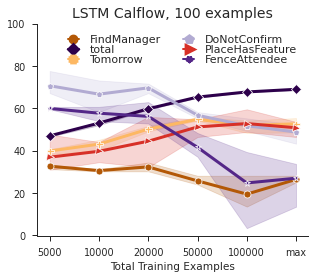

In [53]:
fig, ax = plt.subplots(1,1, figsize=(4.5,4))
fm_data = pd.read_csv("~/papers/incremental_function_learning/results/FindManager_vanilla_lstm_test.csv", index_col=0)
tomorrow_data = pd.read_csv("~/papers/incremental_function_learning/results/Tomorrow_vanilla_lstm_test.csv", index_col=0)
donotconfirm_data = pd.read_csv("~/papers/incremental_function_learning/results/DoNotConfirm_vanilla_lstm_100.csv", index_col=0)
placehasfeature_data = pd.read_csv("~/papers/incremental_function_learning/results/PlaceHasFeature_vanilla_lstm_test.csv", index_col=0)
fenceattendee_data = pd.read_csv("~/papers/incremental_function_learning/results/FenceAttendee_vanilla_lstm_test.csv", index_col=0)


datas = [("FindManager", fm_data), ("Tomorrow", tomorrow_data), ("DoNotConfirm", donotconfirm_data), ("PlaceHasFeature", placehasfeature_data), ("FenceAttendee", fenceattendee_data)]

for i, (name, df) in enumerate(datas):
    df['train'] = df['train'].astype(str)
    datas[i] = (name, df)

plot_calflow(datas, 
            title = "LSTM Calflow, 100 examples", 
            prefix="test", 
            ax=ax, 
            use_coarse=False, 
            use_total=False,
            ymin=None,
            ymax=100,
            legend_kws=dict(ncol=2, fontsize=11, borderpad=0.5, labelspacing=0.0, handlelength=1,
                              handletextpad=1.0, handler_map=handler_map)
            )

plt.tight_layout()

plt.savefig("/home/estengel/papers/incremental_function_learning/figures/for_paper/lstm_calflow.pdf")

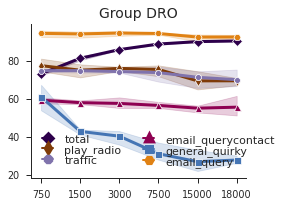

In [59]:


fig, ax = plt.subplots(1, 1, sharex=False, sharey=True, figsize=(4,3))

plot_intent([(50, "/brtx/602-nvme1/estengel/intent_fixed_test/intent_group_dro/"),
             (66, "/brtx/602-nvme1/estengel/intent_fixed_test/intent_group_dro/"), 
             (16, "/brtx/602-nvme1/estengel/intent_fixed_test/intent_group_dro/"), 
             (27, "/brtx/602-nvme1/estengel/intent_fixed_test/intent_group_dro/"), 
             (15, "/brtx/602-nvme1/estengel/intent_fixed_test/intent_group_dro/")], [12, 31, 64],
              title = f"Group DRO", fxn_split=75, ax=ax,
              axis_title=None,
              legend_kws=dict(ncol=2, fontsize=11, borderpad=0.5, labelspacing=0.0, handlelength=1,
                              handletextpad=1.0, handler_map=handler_map))
plt.tight_layout()
plt.savefig("/home/estengel/papers/incremental_function_learning/figures/for_paper/intent_group_dro.pdf")